# BE : Building Modelling

## Chambeau Maël, Nebon Charles, Bouchet Rémy 

#### Objectives:
- Physical analysis of a house 
- Model a controller for indoor temperature
- Discuss the influence of the controller and of the position of the insulation


## Elements of the thermal network

The thermal resistances for conduction are of the form:
$$R_{cd} = \frac{w}{\lambda S}$$
where:

- $w$ is the width of the material, m;
- $\lambda$ - thermal conductvity, W/m K;
- $S$ - surface area of the wall, m²

The thermals resistance for convection are of the form:
$$R_{cv} = \frac{1}{h S}$$
where:
- $h$ is the convection coefficient, W/m² K;
- $S$ - surface area of the wall, m².

The thermal capacities of the wall are of the form:
$$C_{wall}= \rho_{wall} c_{p, wall} w_{wall} S_{wall}$$

The thermal capacity of the air is:
$$C_{air} = \rho_{air} c_{air} V_{air}$$

The radiative short wave (i.e. solar) heat flow rate on each surface is:
$$ \Phi = S G $$
where:
- $\Phi = \begin{bmatrix}
\Phi_1\\ 
\Phi_2\\ 
...\\ 
\Phi_n
\end{bmatrix}$ - vector of total heat flow rates due to solar radiation [W]; 

- $S =\begin{bmatrix}
S_1 & 0 & ... & 0 \\ 
0 & S_2 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & S_n 
\end{bmatrix}$ - matrix of surface areas of walls $i$ [m²].


## Physical analysis and mathematical modelling

![cube](maison.png)
> Simple studio with a bathroom and a living room, including differents electronic components

Let’s consider a cubic building with an HVAC systems controolled by a P-controller.

Here is our choice of sizing for the exterior wall :
![cube](murint.png)

For the window we consider a single glazed glass window with e=20mm and the interior wall is a 100% concrete wall with e=160mm. To simplify the computation we considered that the windows were equivalent to a glass wall in contact with the exterior air.

We neglect the thermal exchanges between our system and the interior of the building, so it remains two walls to consider.


In [1]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0

The dimension and surface areas of the building are:

In [2]:
Va = (1.5*1.85+2.56*3.62)*2.5          # m³ volume of air
ACH = 1             # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration

#propriétés air
d_air=.2                      # kg/m³
c_air=1000               # J/kg.K

#propriétés bois
d_bois=1400
c_bois=2050
cond_bois=0.065
e_porte=0.05
S_porte=2
#propriétés concrete
d_c=2300
c_c=880
cond_c=1.4
e_c=0.16
S_c=6.590*2.5  # m² surface of concrete & insulation 

#propriété Insulation
d_i=25
c_i=1030
cond_i=0.03
e_i=0.08
S_i=S_c

#propriété placo
d_pla=825
c_pla=1225
cond_pla=0.3
e_pla=0.01
S_pla=S_c

#propriété verre
d_v=2500
c_v=750
cond_v=1.4
e_v=0.02
S_v=3.620*2.5  # m² surface of the window 


ε_wLW = 0.9     # long wave wall emmisivity (concrete)
α_wSW = 0.2     # absortivity white surface
ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83    # short wave glass transmitance (glass)
α_gSW = 0.1     # short wave glass absortivity

σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant

Fwg = 1 / 5     # view factor wall - glass

Tm = 20 + 273   # mean temp for radiative exchange

GLW1 = ε_wLW / (1 - ε_wLW) * S_c * 4 * σ * Tm**3
GLW2 = Fwg * S_c * 4 * σ * Tm**3
GLW3 = ε_gLW / (1 - ε_gLW) * S_c* 4 * σ * Tm**3
# long-wave exg. wall-glass
GLW = 1 / (1 / GLW1 + 1 / GLW2 + 1 / GLW3)

Gv = Va_dot * d_air * c_air

g_c =  cond_c/ e_c * S_c
g_pla =  cond_pla/ e_pla * S_pla
g_i =  cond_i/ e_i * S_i
g_v =  cond_v/ e_v * S_v
g_bois =  cond_bois/ e_porte * S_porte

![cube](diag.png)
![cube](leg.png)

The thermal circuit is discribed by the diferential-algebraic set of equations:

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
$$q = G (-A \theta + b)$$

where:
- **A** incidence matrix: shows how the temperature nodes are conected by branches of heat flow. It consists of $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. If flow *m* enters  into the node *n*, then the element (*m, n*) is 1; if flow *m* exits from the node *n*, then the element (*m, n*) is -1; if flow *m* is not conected to node *n*, then the element (*m, n*) is 0.

- **G** conductance matrix: diagonal matrix containing the conductances. Its size is It consists of $n_q \times n_q$,  where $n_q$ is the number of flow branches.

- **b** temperature source vector: if there is no temperature source on the branch *m*, then $b_m = 0$.

- **C** capacity matrix: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- **f** heat flow source vector: if there is no heat flow source in the node *n*, then $f_n = 0$.


**Incidence matrix**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
A = np.zeros([14, 12])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 5], A[6, 6] = -1, 1
A[7, 6], A[7, 7] = -1, 1
A[8, 7], A[8, 8] = 1, -1
A[9, 8] = 1
A[10, 7] = 1
A[10, 9], A[11, 9] = -1, 1
A[13, 7], A[11, 10] = 1, -1
A[12, 10], A[12, 11] = 1, -1
A[13, 11] =- 1
print(A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.]]


**Capacity matrix**

In [4]:
C=np.zeros([12])
C[1]=d_c*c_c*e_c*S_c
C[3]=d_i*c_i*e_i*S_i
C[5]=d_pla*c_pla*e_pla*S_pla
C[8]=d_v*c_v*e_v*S_v
C[10]=d_c*c_c*e_c*S_c
Cdiag=np.diag(C)
print(Cdiag)

[[      0.            0.            0.            0.            0.
        0.            0.            0.            0.            0.
        0.            0.     ]
 [      0.      5335264.            0.            0.            0.
        0.            0.            0.            0.            0.
        0.            0.     ]
 [      0.            0.            0.            0.            0.
        0.            0.            0.            0.            0.
        0.            0.     ]
 [      0.            0.            0.        33938.5           0.
        0.            0.            0.            0.            0.
        0.            0.     ]
 [      0.            0.            0.            0.            0.
        0.            0.            0.            0.            0.
        0.            0.     ]
 [      0.            0.            0.            0.            0.
   166500.46875       0.            0.            0.            0.
        0.            0.     ]
 [      0.

**Conductance matrix**

In [5]:
G=np.zeros([14])

G[1]=25*S_c
G[0]=g_c/2
G[2]=g_c/2
G[3]=g_i/2
G[4]=g_i/2
G[5]=g_pla/2
G[6]=g_pla/2

G[8]=g_v
G[9]=25*S_v
G[10]=g_c/2
G[11]=g_c/2
G[12]=8*(2.02*2.5+1.85*2.50)
G[13]=g_bois
G[7]=GLW+Gv
Gdiag=np.diag(G)
print(Gdiag)

[[ 72.078125     0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.         411.875        0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.          72.078125     0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           3.0890625    0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           3.0890625
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  247.125        0.           0.           0.           0.
    0.    

**Input vector**

The vector of *temperature sources* is **b**. It has the size of the number of branches (in this example 12) and it's element corresponding to a branch without a source is zero. If the flow in a source is from low potential to high potential (i.e. from - to +), the source is positive. Let's give some arbitrary non-zero values to the temperature sources:

In [6]:
b = np.zeros(14)
b[[0,9,11]] = 10+10 + np.array([20, 100, 110])
print(b)

[ 40.   0.   0.   0.   0.   0.   0.   0.   0. 120.   0. 130.   0.   0.]


The vector of heat sources is **f**. It has the size of the number of nodes (in this example 8) and its element corresponding to a node without a heat source is zero. Let's give some arbitrary non-zero values to the heat sources:

In [7]:
f = np.zeros(12)
f[[0, 6, 7,8]] = 10 + np.array([0, 80, 100, 110])

The vector of outputs is **y**. It has the size of the number of nodes (in this example 8). The non-zero values of **y** indicate the nodes that are the outputs of the model. Let's assume that all temperatures are of interest:

In [8]:
y=np.ones(12)

The inputs vector **u** is:

$$\mathbf{u} = \begin{bmatrix}
\mathbf{b}\\ 
\mathbf{f}
\end{bmatrix}$$

where **b** is  the vector of temperature sources and **f** the vector of heat flow sources. Note that in Python, a vector is a row. The **u** vector is obtained as an horizontal stack of the sources that are in the circuit (non-zero elements of **b** and **f**):

In [9]:
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])
u

array([ 40., 120., 130.,  10.,  90., 110., 120.])

## Elements of the thermal network

The state-space representation of the dynamic model is obtained from the differential-algebraic set of equations:

In [10]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, Gdiag, b, Cdiag, f, y)

Let's compare the steady state results obtained with the differential-algebraic equations of the thermal circuit:
$$y_{tc} = (A^T G A)^{-1}(A^T G b + f)$$
and the state-space:
$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$ 

In [11]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ Gdiag @ A) @ (A.T @ Gdiag @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

[ 41.749  42.03   43.64   81.206 118.771 119.241 119.71  121.034 120.901
 125.275  -0.484   3.465]
[ 41.749  42.03   43.64   81.206 118.771 119.241 119.71  121.034 120.901
 125.275  -0.484   3.465]
Max error in steady-state between thermal circuit and state-space: 1.99e-13


We can see that the two models give the same results

## Dynamic simulation


In dynamic simulation, the inputs vary in time. Let's indicate the sources in the circuit by ones:

In [12]:
b = np.zeros(14)
b[[0,9,11]] = 1

f = np.zeros(12)
f[[0, 6, 7,8]] = 1


Let's consider that the output of the circuit is the indoor temperature (i.e. the temperature of node 7):

In [13]:
y = np.zeros(12)
y[[7]] = 1


The state-space representation is obtained from the differential-algebraic equations of the thermal circuit:

In [14]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, Gdiag, b, Cdiag, f, y)

## Time step
The maximum time step for numerical stability of Euler explicit itegration in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$:

$$ \Delta t \leq \min (-2 / \lambda_i) = \min T_i/2$$

where $T_i$ is the time constants, $T_i = - \frac{1}{\lambda_i} $

In [15]:
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 2415.18 s


The maximum time step for numerical stability of Euler explicit integration in time depends on the value of the P-controller gain and if the capacities of the indoor air and window glass are taken into account.




Let's chose a time step smaller than dtmax:

In [16]:
#dt=100
#dt=800
#dt=1200
dt=1800
#dt=2000

## Step response

Let's obtain the dynamic response of the system to a step input. For the duration of simulation:

In [17]:
duration = 3600 * 24 * 2        # [s]

the number of steps is

In [18]:
n = int(np.floor(duration / dt))

The time vector (with time step dt) is

In [19]:
t = np.arange(0, n * dt, dt)    # time

For the input vector u, the outdoor temperatures will be To = 1, the indoor set-point temperature will Tsp =0, and the heat flow sources will be zero.

In [20]:
# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To Tsp Phio Phii Qaux Phia]
u = np.zeros([7, n])
u[0:2, :] = np.ones([2, n])

The vectors for the evolution of temperatures (states) in time for Euler explicit and implicit are:

In [21]:
temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

In [22]:
I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])
        

we obtain the outputs

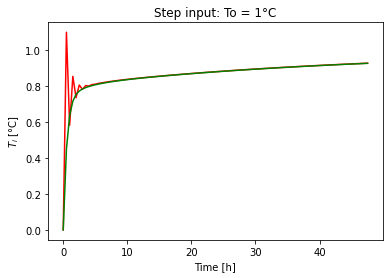

In [23]:
y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T,'r', t / 3600, y_imp.T,'g')
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')
plt.show()

We can see that y_exp(t) has different shapes if we change the time step, when the time step is low, y_exp(t) follow the y_imp curve precisely and if he time step is near dtmax we see with the transitory time needed by y_exp(t) to follow y_imp(t) (here around 5 hours).

In [24]:
b = np.zeros(14)
b[[0,9,11]] = 1
f = np.zeros(12)
ytc = np.linalg.inv(A.T @ Gdiag @ A) @ (A.T @ Gdiag @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[6]:.4f} °C')
print(f'- response to step input:{float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 1.0000 °C
- response to step input:0.9281 °C


## Simulation with weather data

We read the hourly weather data file from start date to end date. The data are for a year (the choice of 2000 for the year is arbitrary).The concerns the city of Lyon.

In [25]:
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-01 12:00:00'
end_date = '2000-01-30 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

From weather data, we calculate the hourly solar radiation on a tilted surface, Φt1 [W]:

In [26]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

The weather data is at the time-step of 1h. It needs to be at time step of dt.

In [27]:
data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

Let's consider the indoor temperature setpoint Ti and auxiliary heat flow Qa constant for the whole simulation period.

In [28]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

The simulation time vector, at time step dtis:

In [29]:
t = dt * np.arange(data.shape[0])

The input vector is formed by the temperature sources $\left [ T_o, T_o , T_{i,sp} \right ]$ and the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]$

In [30]:
u = pd.concat([data['To'], data['To'], data['Ti'],
               α_wSW * S_c * data['Φt1'],
               τ_gSW * α_wSW * S_v * data['Φt1'],
               data['Qa'],
               α_gSW * S_v * data['Φt1']], axis=1)

The initial value of the state-vector can be different of zero:

In [31]:
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

By using Euler equation of discretization :

In [32]:
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):
$$y = C_s \theta + D_s u$$
and the variation of the heat flow of the HVAC system:
$$q_{HVAC} = K_p (T_{i,sp} - y)$$
where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

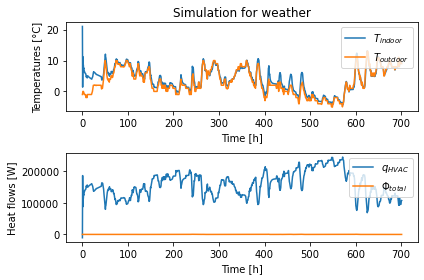

In [33]:
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()



We can deduce from these curves, that with a high time step dt (2000) the 2 curves Tindoor(t) et Toutdoor(t) are really close. 
Globally, even with a smaller time step these txo curves are still close except in the 2 first days (adapting time to the initial values that we cannot realy predict).

Moreover, concerning the control of the HVAC system, we can observe that the more Kp is high the more the indoor temperature is controlled by the ventilation machine. When the machine is in total control of the temperature it copensates the temperature losses and thus the total heat flow is equal to zero. If dt is high enough, the value of Kp will no more influence the control because the machine has not enough time to act on the control of the temperature.

## Conclusion 

We chose to model the temperature exchanges between our system (little flat of 2 pieces) and its environement. We obtained intersting results and wera able to discuss parameters such as Kp and dt.
If we had more time we could mesure the infuence of some other parameters on the thermal control system such as the insulation or the solar heat flow.